<a href="https://colab.research.google.com/github/ChrisP-Bakein6741/Gen_AI2026/blob/main/Copy_of_Image_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# the needed libraries
!pip install diffusers transformers accelerate



In [ ]:
import diffusers
import os

# Disable the problematic progress bar widgets
diffusers.logging.disable_progress_bar()
os.environ["TQDM_DISABLE"] = "1"

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# Load the model into memory
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")





Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


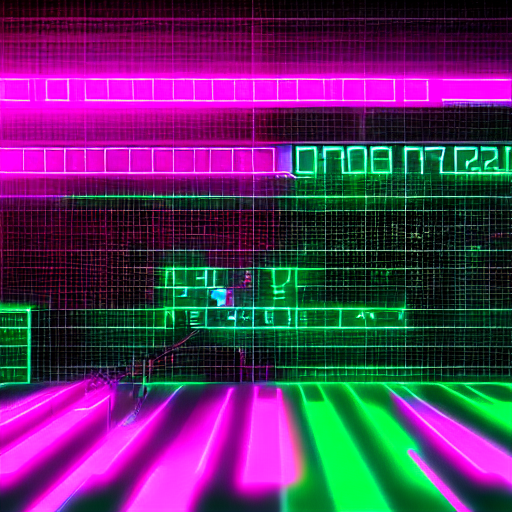

In [ ]:
# Create a generator with a fixed seed
generator = torch.Generator("cuda").manual_seed(60)

pipe.set_progress_bar_config(disable=True)

image = pipe(
    prompt = "A cyberpunk hacker terminal showing green lines of code, reflection of a neon city on the screen, 8k, raytracing.",
    generator=generator,
    num_inference_steps=50
).images[0]

image

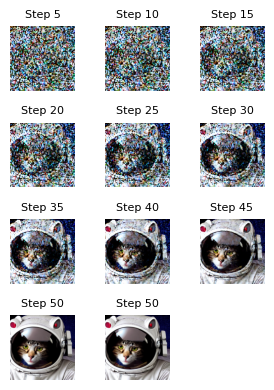

In [ ]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator("cuda").manual_seed(60)
intermediate_images = []

def latents_callback(pipe, step_index, timestep, callback_kwargs):
    # Capture every 5 iterations
    if (step_index + 1) % 5  == 0:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            # Decode and process latent to PIL
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()
            pil_image = pipe.numpy_to_pil(image)[0]
            intermediate_images.append((step_index + 1, pil_image))

    return callback_kwargs

# Run the generation
final_image = pipe(
    prompt="a cat in spacesuit",
    generator=generator,
    num_inference_steps=50,
    callback_on_step_end=latents_callback,
    callback_on_step_end_tensor_inputs=['latents']
).images[0]

# Add the final result to our list
intermediate_images.append((50, final_image))

# --- Display in a Matrix ---
cols = 3
rows = (len(intermediate_images) + cols - 1) // cols
# figsize is (width, height) in inches.
# Since we want roughly 1x1 inch images, we scale by the grid size.
plt.figure(figsize=(cols, rows))

for i, (step, img) in enumerate(intermediate_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Step {step}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

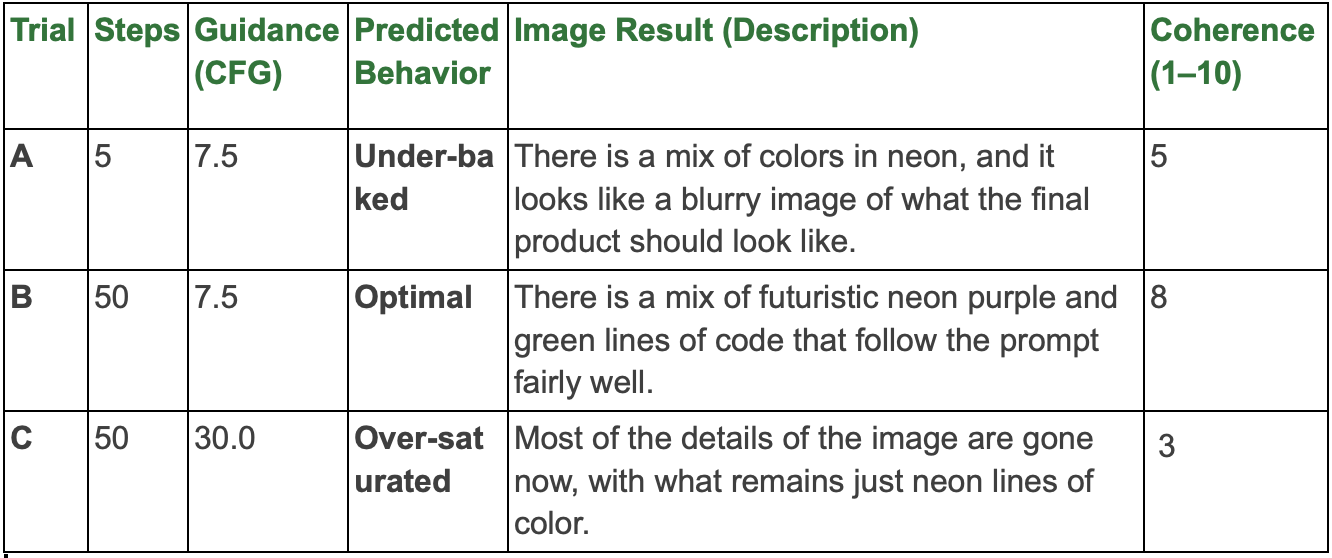

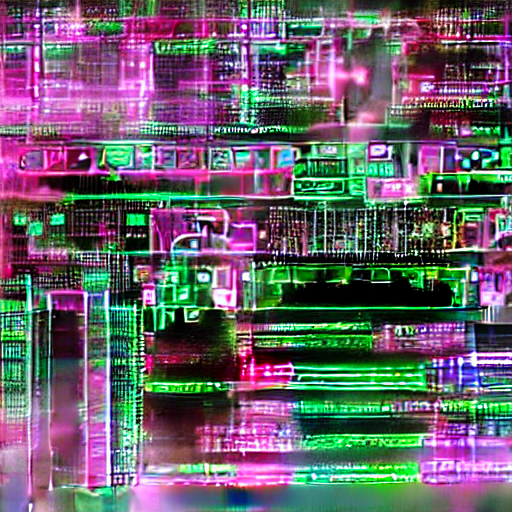

In [ ]:
generator = torch.Generator("cuda").manual_seed(60)
intermediate_images = []

image = pipe(
    prompt="A cyberpunk hacker terminal showing green lines of code",
    num_inference_steps=5,

    # Adjust this value for your experiments:
    guidance_scale=7.5,

    generator=generator
).images[0]

image

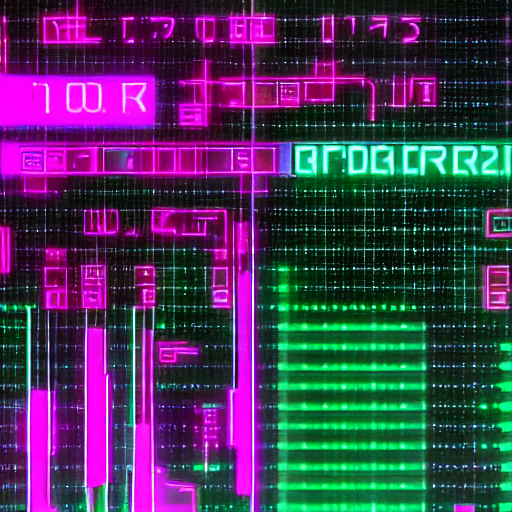

In [ ]:
generator = torch.Generator("cuda").manual_seed(60)
intermediate_images = []

image = pipe(
    prompt="A cyberpunk hacker terminal showing green lines of code",
    num_inference_steps=50,

    # Adjust this value for your experiments:
    guidance_scale=7.5,

    generator=generator
).images[0]

image

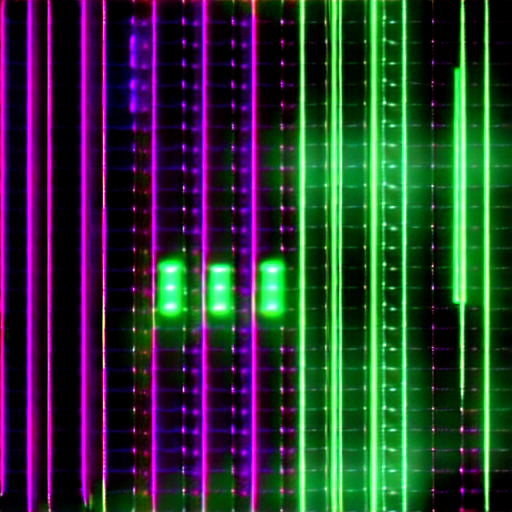

In [ ]:
generator = torch.Generator("cuda").manual_seed(60)
intermediate_images = []

image = pipe(
    prompt="A cyberpunk hacker terminal showing green lines of code",
    num_inference_steps=50,

    # Adjust this value for your experiments:
    guidance_scale=30,

    generator=generator
).images[0]

image

Analysis

Answer the following questions based on your specific results:

Compare Trial A to Trial B. Why does 5 steps result in a blurry ghost of an image?

The less steps the AI is given, the more blurry it will be. Each step increases the amount of times the AI can chip away at the image to make it more clear.

In Trial C, look at the colors. Did they become more realistic, or did they start to become too bright/dark? Explain why.

The colors have become too bright and contrasting in trial C. This is because,when the guidance scale is cranked up, the model is pushed to its limits and makes things too constracting.

Does doubling the steps double the time it takes to generate the image? Why or why not?

Yes from trial A to B the time went from 1 second to more than double that at 8 seconds. When you increase the amount of steps the AI can take you are allowing for the AI to take its time to clean up the image.